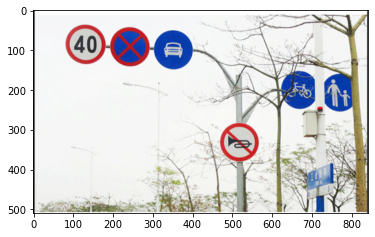

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from skimage import feature as ft
import math

#加载原图
#img = cv2.imread('../Dataset_1/images/002_0031.png')
img = cv2.imread('../Extra_data/m2.png')
fig = plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

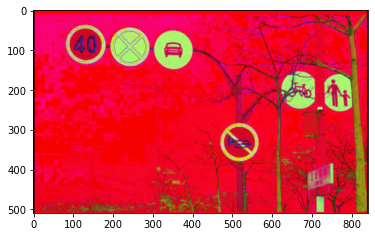

In [52]:
#转化为HSV通道
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
fig = plt.figure()
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))

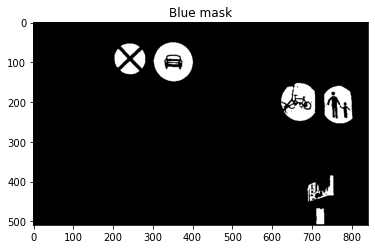

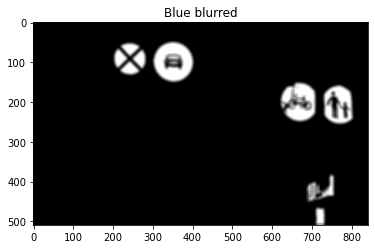

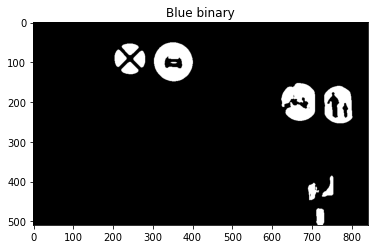

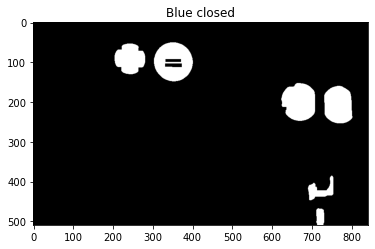

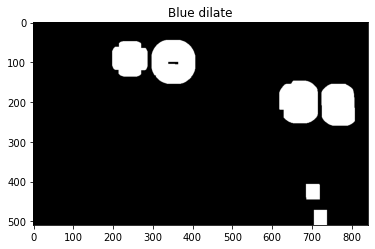

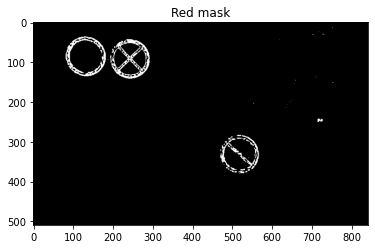

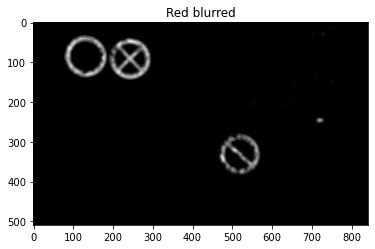

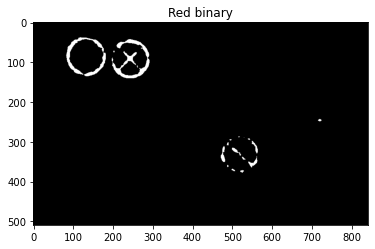

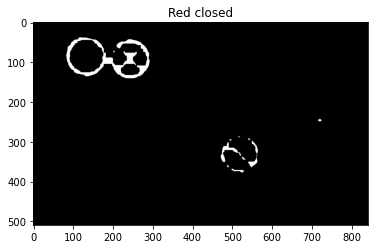

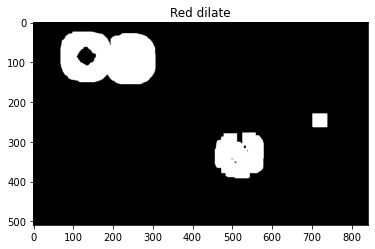

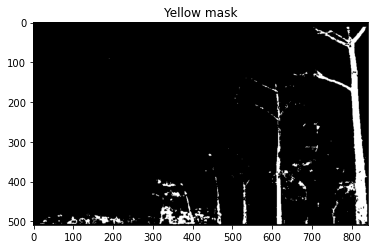

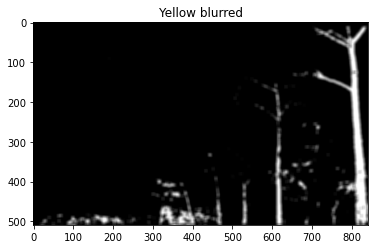

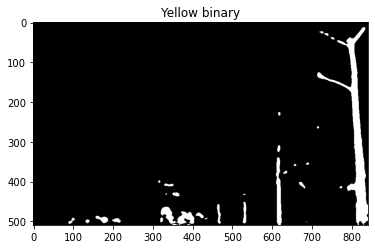

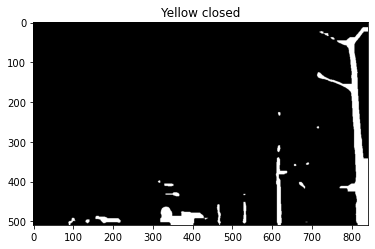

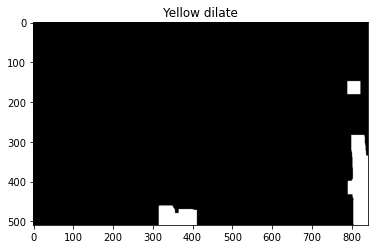

In [53]:
#BLUE RED YELLOW
COLOR = np.array([[106, 80, 80], [124, 255, 255], [156, 43, 46], [180, 255, 255], [18, 43, 46], [34, 255, 255]])
COLOR_name = ['Blue ', 'Red ', 'Yellow ']
iterations = [[9, 16], [1, 16], [9, 16]]
Contours = []
index = 0
while index < len(COLOR):
    mask = cv2.inRange(hsv, COLOR[index], COLOR[index + 1])
    #模糊
    blurred = cv2.blur(mask, (9, 9))
    #二值化
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    #使区域闭合无空隙
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    #腐蚀和膨胀
    #腐蚀操作将会腐蚀图像中白色像素，以此来消除小斑点，
    #而膨胀操作将使剩余的白色像素扩张并重新增长回去。
    erode = cv2.erode(closed, None, iterations=iterations[int(index / 2)][0])
    dilate = cv2.dilate(erode, None, iterations=iterations[int(index / 2)][1])
    # 查找轮廓
    contours, hierarchy = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for con in contours:
        Contours.append(con)

    plt.figure()
    plt.title(COLOR_name[int(index / 2)] + 'mask')
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.title(COLOR_name[int(index / 2)] + 'blurred')
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.title(COLOR_name[int(index / 2)] + 'binary')
    plt.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.title(COLOR_name[int(index / 2)] + 'closed')
    plt.imshow(cv2.cvtColor(closed, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.title(COLOR_name[int(index / 2)] + 'dilate')
    plt.imshow(cv2.cvtColor(dilate, cv2.COLOR_BGR2RGB))
    index += 2

Detected contours: 12


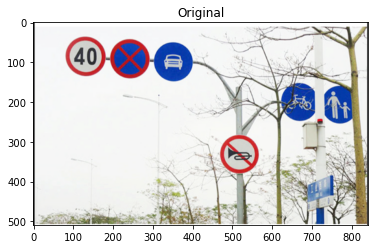

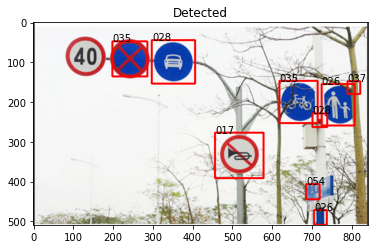

In [54]:
# save model before by
# joblib.dump(clf, 'beginner.pkl')

# load model
model = joblib.load('beginner.pkl')

res = img.copy()
labels = []
sub_pic = []
texts = []
for con in Contours:
    #轮廓转换为矩形
    rect = cv2.minAreaRect(con)
    #矩形转换为box
    box = np.int0(cv2.boxPoints(rect))
    #计算矩形的行列
    h1 = max([box][0][0][1], [box][0][1][1], [box][0][2][1], [box][0][3][1])
    h2 = min([box][0][0][1], [box][0][1][1], [box][0][2][1], [box][0][3][1])
    l1 = max([box][0][0][0], [box][0][1][0], [box][0][2][0], [box][0][3][0])
    l2 = min([box][0][0][0], [box][0][1][0], [box][0][2][0], [box][0][3][0])
    #加上防错处理，确保裁剪区域无异常
    if h1 - h2 > 0 and l1 - l2 > 0:
        if (h1 - h2) / (l1 - l2) > 1.3 or (l1 - l2) / (h1 - h2) > 1.3:
            continue
        #裁剪矩形区域
        temp1 = img[h2:h1, l2:l1]
        temp = cv2.cvtColor(temp1, cv2.COLOR_BGR2GRAY)
        temp = cv2.resize(temp, (48, 48))
        fea = ft.hog(temp, orientations=8, pixels_per_cell=(10, 10), cells_per_block=(1, 1), visualize=False,
                     multichannel=False)
        label = model.predict([fea])
        labels.append(label[0])
        #在原图画出目标区域
        cv2.drawContours(res, [box], -1, (0, 0, 255), 3)
        texts.append([h2, l2])
        sub_pic.append(temp1)

print('Detected contours:', len(Contours))
#显示原图
plt.figure()
plt.title('Original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#结果图
plt.figure()
plt.title('Detected')
i = 0
for text in texts:
    plt.text(text[1], text[0], labels[i])
    i += 1
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

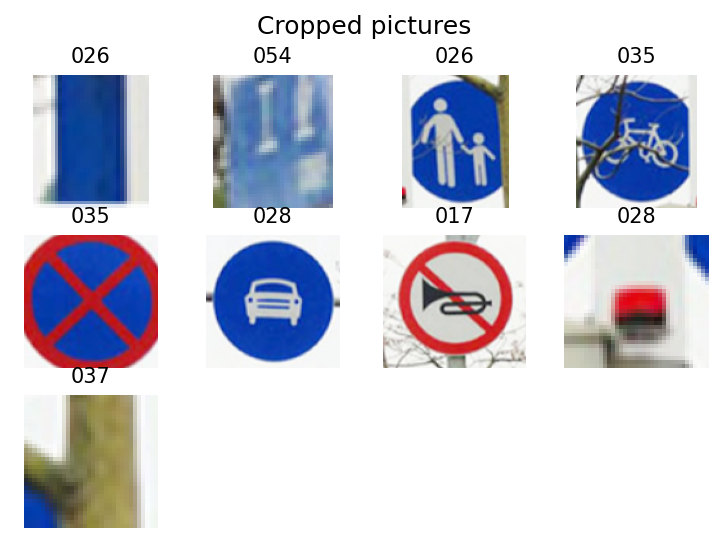

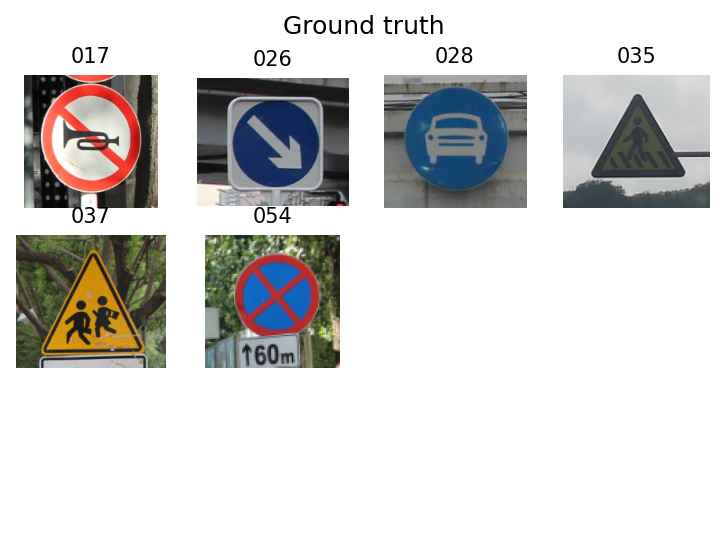

In [55]:
#裁剪区域图
fig = plt.figure(dpi=150)
plt.title('Cropped pictures', pad=20)
plt.axis('off')
col = 4
row = math.ceil(len(sub_pic) / col)
for i in range(len(sub_pic)):
    fig.add_subplot(row, col, i + 1)
    plt.title(labels[i], fontsize=10)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(sub_pic[i], cv2.COLOR_BGR2RGB))

#对照答案图
dataset_path = "../Dataset_1/images/"
labels = np.unique(labels)
fig = plt.figure(dpi=150)
plt.title('Ground truth', pad=20)
plt.axis('off')
for i in range(len(labels)):
    fig.add_subplot(row, col, i + 1)
    plt.title(labels[i], fontsize=10)
    plt.axis('off')
    im = cv2.imread(dataset_path + labels[i] + '_0001.png')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

